In [1]:
#Import packages
import time
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.vgg import vgg19
import torch.nn as nn
import torch.nn.functional as F
import torch
from skimage import img_as_ubyte
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # dataset
import matplotlib.pyplot as plt
import scipy
import numpy as np
import argparse
import glob
import imageio
from skimage import color
import numpy
import natsort
import scipy
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import pprint
from scipy.ndimage import correlate
from scipy.ndimage.filters import gaussian_gradient_magnitude
import torchvision.datasets as dset
import torch.utils.data as data
import os
import os.path
from tkinter import *
import tkinter as tk
import tkinter.font as tkFont
from PIL import ImageTk, Image
import pylab
import cv2
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_properties(0).total_memory)

11811160064


In [3]:
import multiprocessing

multiprocessing.cpu_count()

12

In [4]:
#define the hyperparameters
image_length = 256
image_width  = 256
mr_channels  = 1
gray_channels = 1
pet_channels = 4    
rgb_channels = 3     
batch_size   = 1
EPOCH = 50
learning_rate = 0.002 

In [5]:
#load the train mri data
filenames = os.listdir('C:/Users/horan/Desktop/Suraka/Training/MRI')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/Suraka/Training/MRI')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    train_mri[i,:,:] =(imageio.imread(data[i]))
    train_mri[i,:,:] =(train_mri[i,:,:] - np.min(train_mri[i,:,:])) / (np.max(train_mri[i,:,:]) - np.min(train_mri[i,:,:]))
    train_mri[i,:,:] = np.float32(train_mri[i,:,:])

In [6]:
#expand dimension to add the channel
train_mri = np.expand_dims(train_mri,axis=1)

In [7]:
#verify the shape matches the pytorch standard
train_mri.shape

(272, 1, 256, 256)

In [8]:
#convert the MRI training data to pytorch tensor
train_mri_tensor = torch.from_numpy(train_mri).float()
train_mri_tensor.shape

torch.Size([272, 1, 256, 256])

In [9]:
#load the train pet data
filenames = os.listdir('C:/Users/horan/Desktop/Suraka/Training/PET')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/Suraka/Training/PET')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_other = np.zeros((len(data),image_width,image_length,pet_channels),dtype=float)
train_pet = np.zeros((len(data),image_width,image_length),dtype=float)
for i in range(len(data)):
    train_other[i,:,:,:] =(imageio.imread(data[i]))
    train_pet[i,:,:] = 0.2989 * train_other[i,:,:,0] + 0.5870 *  train_other[i,:,:,1]  + 0.1140 * train_other[i,:,:,2]
    train_pet[i,:,:] =(train_pet[i,:,:] - np.min(train_pet[i,:,:])) / (np.max(train_pet[i,:,:]) - np.min(train_pet[i,:,:]))

In [10]:
#expand the dimension to add the channel
train_pet = np.expand_dims(train_pet,axis=1)

In [11]:
#verify the shape matches the pytorch standard
train_pet.shape

(272, 1, 256, 256)

In [12]:
#convert the PET training data to pytorch tensor
train_pet_tensor = torch.from_numpy(train_pet).float()
train_pet_tensor.shape

torch.Size([272, 1, 256, 256])

In [13]:
#define the generator network
class Generator(nn.Module):
    def  __init__(self):
        super(Generator, self).__init__()
        ##### Encoder Layer 1#####
        self.gen_layer1 = nn.Sequential( #input shape (,2,256,256)
                         nn.Conv2d(in_channels=2, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())        
        ##### Encoder Layer 2#####
        self.gen_layer2 = nn.Sequential( 
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())    
        ##### Encoder Layer 3#####
        self.gen_layer3 = nn.Sequential(
                         nn.Conv2d(in_channels=96, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())     
        ##### Encoder Layer 4#####
        self.gen_layer4 = nn.Sequential( 
                         nn.Conv2d(in_channels=144, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())      
        ##### Encoder Layer 5#####
        self.gen_layer5 = nn.Sequential( 
                         nn.Conv2d(in_channels=192, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())        
        
        ##### Decoder Layer 1#####
        self.gen_layer6 = nn.Sequential( 
                         nn.Conv2d(in_channels=240, out_channels=240, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(240),
                         nn.ReLU())     
        ##### Decoder Layer 2#####
        self.gen_layer7 = nn.Sequential( 
                         nn.Conv2d(in_channels=240, out_channels=128, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(128),
                         nn.ReLU())       
        ##### Decoder Layer 3#####
        self.gen_layer8 = nn.Sequential( 
                         nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(64),
                         nn.ReLU())       
        ##### Decoder Layer 4#####
        self.gen_layer9 = nn.Sequential(
                         nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(32),
                         nn.ReLU())       
        ##### Decoder Layer 5#####
        self.gen_layer10 = nn.Sequential( 
                         nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(1),
                         nn.Tanh())        


    def forward(self, x, y):
        #Encoder 
        xy = torch.cat((x,y),1)
        x1 = self.gen_layer1(xy)
        x2 = self.gen_layer2(x1)
        concat1 = torch.cat((x1,x2),1)
        x3 = self.gen_layer3(concat1)
        concat2 = torch.cat((x3,concat1),1)
        x4 = self.gen_layer4(concat2)
        concat3 = torch.cat((x4,concat2),1)
        x5 = self.gen_layer5(concat3)
        concat4 = torch.cat((x5,concat3),1)
        #Decoder
        x6 = self.gen_layer6(concat4)
        x7 = self.gen_layer7(x6)
        x8 = self.gen_layer8(x7)
        x9 = self.gen_layer9(x8)
        fused = self.gen_layer10(x9)
        return fused

gen = Generator().to(device)
gen = gen.float()
print(gen)

Generator(
  (gen_layer1): Sequential(
    (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (gen_layer2): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (gen_layer3): Sequential(
    (0): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (gen_layer4): Sequential(
    (0): Conv2d(144, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (gen_layer5): Sequential(
    (0): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, m

In [14]:
#define the generator network
class Discriminator1(nn.Module):
    def  __init__(self):
        super(Discriminator1, self).__init__()
        #####Layer 1#####
        self.disc_layer1 = nn.Sequential( #input shape (,1,256,256)
                         nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
                         nn.ReLU())   
        #####Layer 2#####
        self.disc_layer2 = nn.Sequential( 
                         nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
                         nn.BatchNorm2d(32),
                         nn.ReLU()) 
        #####Layer 3#####
        self.disc_layer3 = nn.Sequential( 
                         nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
                         nn.BatchNorm2d(64),  
                         nn.ReLU())  

        
    def forward(self, x):
        #layer 1
        x1 = self.disc_layer1(x)
        #layer 2
        x2 = self.disc_layer2(x1)
        #layer 3
        x3 = self.disc_layer3(x2)
        #flatten the output
        x4 = torch.flatten(x3, start_dim=1)
        #linear and tanh layer
        lin = torch.nn.Linear(65536,1).to(device)  
        x5 = lin(x4)
        score = torch.tanh(x5)
        #print(score.shape)
        return score

disc1 = Discriminator1().to(device)
disc1 = disc1.float()
print(disc1)

Discriminator1(
  (disc_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (disc_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (disc_layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)


In [15]:
#define the generator network
class Discriminator2(nn.Module):
    def  __init__(self):
        super(Discriminator2, self).__init__()
        #####Layer 1#####
        self.disc_layer1 = nn.Sequential( #input shape (,1,256,256)
                         nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
                         nn.ReLU())   
        #####Layer 2#####
        self.disc_layer2 = nn.Sequential( 
                         nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
                         nn.BatchNorm2d(32),
                         nn.ReLU()) 
        #####Layer 3#####
        self.disc_layer3 = nn.Sequential( 
                         nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
                         nn.BatchNorm2d(64),  
                         nn.ReLU())  

        
    def forward(self, x):
        #layer 1
        x1 = self.disc_layer1(x)
        #layer 2
        x2 = self.disc_layer2(x1)
        #layer 3
        x3 = self.disc_layer3(x2)
        #flatten the output
        x4 = torch.flatten(x3, start_dim=1)
        #linear and tanh layer
        lin = torch.nn.Linear(65536,1).to(device)  
        x5 = lin(x4)
        score = torch.tanh(x5)
        #print(score.shape)
        return score

disc2 = Discriminator2().to(device)
disc2 = disc2.float()
print(disc2)

Discriminator2(
  (disc_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (disc_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (disc_layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)


In [16]:
#define the optimizers and loss functions 
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=learning_rate)   # optimize all cnn parameters
disc1_optimizer = torch.optim.Adam(disc1.parameters(), lr=learning_rate)   # optimize all cnn parameters
disc2_optimizer = torch.optim.Adam(disc2.parameters(), lr=learning_rate)   # optimize all cnn parameters
#l2_loss   = nn.MSELoss() #MSEloss

In [20]:
# perform the training
counter = 0
Tensor = torch.cuda.FloatTensor if device else torch.FloatTensor
# Adversarial ground truths
one = Tensor(np.ones((1)))
start_time = time.time()
lamda = 1
ep_ssim_mri_loss = []
ep_ssim_pet_loss = []
ep_adv_loss = []
ep_disc_loss = []
ep_gen_loss =[]
for epoch in range(EPOCH):
    ssim_mri_Loss = []
    ssim_pet_Loss   = []
    adv_Loss = []
    gen_Loss = []
    disc_Loss = []
    #run batch images
    batch_idxs = 272 // batch_size
    for idx in range(0, batch_idxs):
        #ge tthe mri and pet batches
        b_x = train_mri_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:].to(device)
        b_y = train_pet_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:].to(device)
        counter += 1
        
        #clear the generator gradients
        gen_optimizer.zero_grad()    

        #get a fused image from generator
        output = gen(b_x,b_y)               # gen output
        
        #feed the fused image into the discriminator 1 and 2
        fused_disc_score1 = disc1(output)
        fused_disc_score2 = disc2(output)        
        
        #define the generator loss
        ssim_loss_mri = 1 - ssim(output, b_x,data_range=1)
        ssim_loss_pet = 1 - ssim(output, b_y,data_range=1)
        ssim_loss = ssim_loss_mri + ssim_loss_pet
        adv_loss1 = -torch.mean(torch.log(fused_disc_score1))
        adv_loss2 = -torch.mean(torch.log(fused_disc_score2))
        gen_loss = ssim_loss + adv_loss1 + adv_loss2
        
        #update the generator
        gen_loss.backward(retain_graph=True)                 # backpropagation, compute gradients
        gen_optimizer.step()                # apply gradients
        
        #clear the discriminator gradients
        disc1_optimizer.zero_grad()  
        disc2_optimizer.zero_grad()      
        
        #feed the MRI image and PET images into the discriminator 1 and 2 respectively
        mri_disc_score = disc1(b_x.detach())
        pet_disc_score = disc2(b_y.detach())
        
        #define the discriminator loss
        disc1_real = -torch.mean(torch.log(mri_disc_score))
        disc2_real = -torch.mean(torch.log(pet_disc_score))
        disc1_fake = -torch.mean(torch.log(one - fused_disc_score1))
        disc2_fake = -torch.mean(torch.log(one - fused_disc_score2))
        disc_loss = disc1_real + disc2_real + disc1_fake + disc2_fake
        
        #update the discriminator
        disc_loss.backward()                 # backpropagation, compute gradients
        disc1_optimizer.step()                # apply gradients  
        disc2_optimizer.step()                # apply gradients 

        #store all the loss values at each epoch
        ssim_mri_Loss.append(ssim_loss_mri.item())
        ssim_pet_Loss.append(ssim_loss_pet.item())
        gen_Loss.append(gen_loss.item())
        disc_Loss.append(disc_loss.item())
        if counter % 100 == 0:
            print("Epoch: [%2d],step: [%2d], mri_ssim_loss: [%.8f], pet_ssim_loss: [%.8f], gen_loss: [%.8f], disc_loss: [%.8f]" 
            %(epoch, counter, ssim_loss_mri, ssim_loss_pet, gen_loss, disc_loss))
    
    av_ssim_mri_loss = np.average(ssim_mri_Loss)
    ep_ssim_mri_loss.append(av_ssim_mri_loss)
    
    av_ssim_pet_loss = np.average(ssim_pet_Loss)
    ep_ssim_pet_loss.append(av_ssim_pet_loss)
    
    av_gen_loss = np.average(gen_Loss)
    ep_gen_loss.append(av_gen_loss)
    
    av_disc_loss = np.average(disc_Loss)
    ep_disc_loss.append(av_disc_loss)
    
    if(epoch == EPOCH -1):
        #Save a checkpoint
        torch.save(gen, 'C:/Users/horan/Desktop/Suraka/.ipynb_checkpoints/DDcGAN/checkpoint_gen.pth') 
        torch.save(disc, 'C:/Users/horan/Desktop/Suraka/.ipynb_checkpoints/DDcGAN/checkpoint_disc.pth') 

Epoch: [ 0],step: [100], mri_ssim_loss: [0.98275131], pet_ssim_loss: [0.97381878], gen_loss: [7.25000858], disc_loss: [nan]
Epoch: [ 0],step: [200], mri_ssim_loss: [1.05526340], pet_ssim_loss: [1.09247267], gen_loss: [nan], disc_loss: [nan]
Epoch: [ 1],step: [300], mri_ssim_loss: [0.99793130], pet_ssim_loss: [0.99350160], gen_loss: [6.88475800], disc_loss: [nan]
Epoch: [ 1],step: [400], mri_ssim_loss: [0.97720635], pet_ssim_loss: [0.95596385], gen_loss: [nan], disc_loss: [nan]
Epoch: [ 1],step: [500], mri_ssim_loss: [1.13062871], pet_ssim_loss: [1.10033822], gen_loss: [nan], disc_loss: [7.43722296]
Epoch: [ 2],step: [600], mri_ssim_loss: [1.01831174], pet_ssim_loss: [1.04639339], gen_loss: [nan], disc_loss: [nan]
Epoch: [ 2],step: [700], mri_ssim_loss: [1.02742219], pet_ssim_loss: [1.06731546], gen_loss: [nan], disc_loss: [2.54065228]
Epoch: [ 2],step: [800], mri_ssim_loss: [1.04938662], pet_ssim_loss: [1.03140306], gen_loss: [nan], disc_loss: [nan]
Epoch: [ 3],step: [900], mri_ssim_lo

Epoch: [24],step: [6800], mri_ssim_loss: [0.94006497], pet_ssim_loss: [0.93713683], gen_loss: [nan], disc_loss: [nan]
Epoch: [25],step: [6900], mri_ssim_loss: [0.97336388], pet_ssim_loss: [0.94279027], gen_loss: [nan], disc_loss: [nan]
Epoch: [25],step: [7000], mri_ssim_loss: [0.92244852], pet_ssim_loss: [0.85726213], gen_loss: [4.39884186], disc_loss: [nan]
Epoch: [26],step: [7100], mri_ssim_loss: [0.96547002], pet_ssim_loss: [0.81897056], gen_loss: [nan], disc_loss: [nan]
Epoch: [26],step: [7200], mri_ssim_loss: [0.98333991], pet_ssim_loss: [0.93523610], gen_loss: [nan], disc_loss: [nan]
Epoch: [26],step: [7300], mri_ssim_loss: [0.96276587], pet_ssim_loss: [0.88682091], gen_loss: [nan], disc_loss: [nan]
Epoch: [27],step: [7400], mri_ssim_loss: [0.91923845], pet_ssim_loss: [0.89240211], gen_loss: [nan], disc_loss: [3.05655622]
Epoch: [27],step: [7500], mri_ssim_loss: [0.94408119], pet_ssim_loss: [0.88941497], gen_loss: [nan], disc_loss: [nan]
Epoch: [27],step: [7600], mri_ssim_loss: [

Epoch: [49],step: [13600], mri_ssim_loss: [1.01977551], pet_ssim_loss: [0.93285632], gen_loss: [4.75679302], disc_loss: [5.82357693]


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


NameError: name 'disc' is not defined

In [21]:
l1 = np.asarray(ep_ssim_mri_loss)
l2 = np.asarray(ep_ssim_pet_loss)
l4 = np.asarray(ep_gen_loss)
l5 = np.asarray(ep_disc_loss)

In [28]:
h5f = h5py.File('C:/Users/horan/Desktop/Suraka/Loss curves/DDcGAN/H5 Files/Loss_GEN.h5', 'w')
h5f.create_dataset('MRI_dataset', data=l4)
h5f.close()

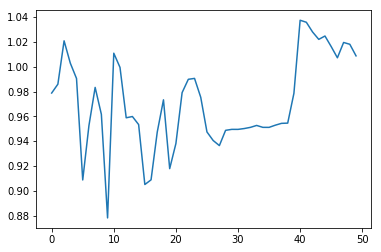

In [29]:
plt.plot(l1)
#plt.savefig('C:/Users/horan/Desktop/Suraka/Loss curves/VIFNet/Loss curves/SSIM_MRI_loss_curve.png', bbox_inches = 'tight',pad_inches = 0)
#plt.close()

In [ ]:
#load the test input MRI dataset
filenames = os.listdir('C:/Users/horan/Desktop/Suraka/MRI/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/Suraka/MRI/')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
test_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_mri[i,:,:] =(imageio.imread(data[i]))
    test_mri[i,:,:] =(test_mri[i,:,:] - np.min(test_mri[i,:,:])) / (np.max(test_mri[i,:,:]) - np.min(test_mri[i,:,:]))
    test_mri[i,:,:] = np.float32(test_mri[i,:,:])

In [ ]:
#expand dimension to add the channel
test_mri = np.expand_dims(test_mri,axis=1)
#verify the shape matches the pytorch standard
test_mri.shape

In [ ]:
#verify the test mri image
#test_mri = test_mri[0,:,:,:]
#test_mri = np.expand_dims(test_mri,axis=0)
plt.imshow(test_mri[0,0,:,:],'gray')
#plt.savefig('MRI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#convert the MRI Testing data to pytorch tensor
test_mri_tensor = torch.from_numpy(test_mri).float()
print(test_mri_tensor.shape)
test_mri_tensor.requires_grad =True

In [ ]:
#load the test input PET dataset
filenames = os.listdir('C:/Users/horan/Desktop/Suraka/PET/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/Suraka/PET/')
data = glob.glob(os.path.join(dataset, "*.png"))
data = natsort.natsorted(data,reverse=False)
test_pet = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_pet[i,:,:] =(imageio.imread(data[i]))
    test_pet[i,:,:] =(test_pet[i,:,:] - np.min(test_pet[i,:,:])) / (np.max(test_pet[i,:,:]) - np.min(test_pet[i,:,:]))
    test_pet[i,:,:] = np.float32(test_pet[i,:,:])

In [ ]:
#expand dimension to add the channel
test_pet = np.expand_dims(test_pet,axis=1)
#verify the shape matches the pytorch standard
test_pet.shape 

In [ ]:
#verify the test pet image
#test_pet = test_pet[2,:,:,:]
#test_pet = np.expand_dims(test_pet,axis=0)
plt.imshow(test_pet[0,0,:,:],'gray')

In [ ]:
plt.imshow(test_pet[0,0,:,:],'gray')
#plt.savefig('PET.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#convert the MRI Testing data to pytorch tensor
test_pet_tensor = torch.from_numpy(test_pet).float()
print(test_pet_tensor.shape)
test_pet_tensor.requires_grad =True

In [ ]:
#load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen =torch.load('C:/Users/horan/Desktop/Suraka/.ipynb_checkpoints/FuseGAN/checkpoint_gen.pth')
gen.eval()

In [ ]:
#predicted the fused image
fused = gen(test_mri_tensor.to(device), test_pet_tensor.to(device))
fused_numpy = fused.data.cpu().numpy()

In [ ]:
fused.shape

In [ ]:
#verify the output image
plt.imshow(fused_numpy[0,0,:,:],'gray')
#plt.savefig('Fused.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#imageio.imwrite('C:/Users/horan/Desktop/Suraka/Fused/Fused.png',np.uint8(cv2.normalize(fused_numpy[0,0,:,:], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)))

In [ ]:
#calculate the guidance image for MRI and PET wrt to the fused image
time1 = time.time()
count = 0 
guide_fuse_mri = np.zeros((256,256),dtype=float)
guide_fuse_pet = np.zeros((256,256),dtype=float)

for y_coord in range(0,256):
    for x_coord in range(0,256):
        jacob_fuse_mri = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_mri_tensor, retain_graph=True, create_graph=True)[0]
        jacob_numpy_mri = np.squeeze(jacob_fuse_mri.data.cpu().numpy())  
        guide_fuse_mri[y_coord,x_coord] = jacob_numpy_mri[y_coord,x_coord]
        jacob_fuse_pet = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_pet_tensor, retain_graph=True, create_graph=True)[0]
        jacob_numpy_pet = np.squeeze(jacob_fuse_pet.data.cpu().numpy())  
        guide_fuse_pet[y_coord,x_coord] = jacob_numpy_pet[y_coord,x_coord]
        count += 1
        if count % 100 == 0:
            print('Count is %d' %count)
time2 = time.time()
print('Time taken to compute is %d seconds' %(time2-time1))

In [ ]:
plt.imshow(guide_fuse_mri,cmap='viridis')
plt.colorbar()
#plt.savefig('Jacob_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#guide_fuse_mri.shape

In [ ]:
#plt.imshow(guide_fuse_pet,cmap='viridis')
#plt.colorbar()
#plt.savefig('Jacob_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#guide_fuse_pet.shape

In [ ]:
#plt.imshow(fused_RGB)
#plt.savefig('Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#plt.imshow(mri_RGB)
#plt.savefig('MRI_RGB.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#plt.imshow(pet_RGB)
#plt.savefig('PET_RGB.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#h5f = h5py.File('C:/Users/horan/Desktop/Suraka/Jacobian_MRI.h5', 'w')
#h5f.create_dataset('MRI_dataset', data=guide_fuse_mri)
#h5f.close()

In [ ]:
#h5f = h5py.File('C:/Users/horan/Desktop/Suraka/Jacobian_PET.h5', 'w')
#h5f.create_dataset('PET_dataset', data=guide_fuse_pet)
#h5f.close()

In [ ]:
hf = h5py.File('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/H5 Files/Jacobian_MRI.h5', 'r')
guide_fuse_mri =  np.array(hf.get('MRI_dataset'))
hf.close()

In [ ]:
plt.imshow(guide_fuse_mri,cmap='viridis')
plt.colorbar()

In [ ]:
hf = h5py.File('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/H5 Files/Jacobian_PET.h5', 'r')
guide_fuse_pet =  np.array(hf.get('PET_dataset'))
hf.close()

In [ ]:
plt.imshow(guide_fuse_pet,cmap='viridis')
plt.colorbar()

In [ ]:
#define overlay images
fused_RGB = np.zeros((256,256,3),dtype=float)
mri_RGB   = np.zeros((256,256,3),dtype=float)
pet_RGB   = np.zeros((256,256,3),dtype=float)

In [ ]:
fused_RGB[:,:,0]  = guide_fuse_mri 
fused_RGB[:,:,1]  = guide_fuse_pet 
fused_RGB[:,:,2]  = fused_numpy[0,0,:,:]

In [ ]:
plt.imshow(fused_RGB)

In [ ]:
mri_RGB[:,:,0]  = guide_fuse_mri
mri_RGB[:,:,1]  = guide_fuse_pet 
mri_RGB[:,:,2]  = test_mri[0,0,:,:]

In [ ]:
plt.imshow(mri_RGB)

In [ ]:
pet_RGB[:,:,0]  = guide_fuse_mri
pet_RGB[:,:,1]  = guide_fuse_pet 
pet_RGB[:,:,2]  = test_pet[0,0,:,:]

In [ ]:
plt.imshow(pet_RGB)

In [ ]:
#define the window
root = Tk()  
root.title('Visualisation of fusion networks')
root.configure(background='white')


#Label the images
#fontStyle = tkFont.Font(family="Lucida Grande", size=15)
#w1 = tk.Label(root, bg='white', font=fontStyle, text="Fused Image")
#w1.grid(row=0, column=1)
#w1.pack()

#define the frame
canvasframe = Frame(root)  # define Input and output frame
buttonframe = Frame(root)  # define button frame
canvasframe.pack()  # pack the Input and Output frame
buttonframe.pack()  # pack the button frame


#define the canvas
canvas = Canvas(canvasframe, width=1800, height=920, bg = 'white')
canvas.grid(row=0, column=0)

#Insert fused image to the canvas
img_fused = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/Suraka/Fused/Fused.png") # load the image
canvas.create_image(0, 0, image=img_fused, anchor=NW)

#Insert MRI image to the canvas
img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/Suraka/MRI/MRI.gif") # load the image
canvas.create_image(620, 0, image=img_mri, anchor=NW)

#Insert PET image to the canvas
img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/Suraka/PET/3.png") # load the image
canvas.create_image(1240, 0, image=img_pet, anchor=NW)

def start_mouseover():  # function called when user clicks the button 
    # link the function to the left-mouse-click event
    canvas.bind("<B1-Motion>", Coordinates)

def Coordinates(event): # function called when left-mouse-button is clicked with a mouseover
    x_coord = event.x  # save x and y coordinates selected by the user   
    y_coord = event.y
    print('mouse position is at' + '(' + str(y_coord) + ',' + str(x_coord) + ')', end='\r')
    #display the output MRI Jacobian image
    #img_MR_out = ImageTk.PhotoImage(file ='C:/Users/cgvadmin/Desktop/Suraka/Fused_MRI/im_' + str(y_coord) + '_' + str(x_coord) + '.png') # load the image
    jacobian_fuse_mri = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_mri_tensor, retain_graph=True, create_graph=True)[0]
    jacobian_fuse_pet = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_pet_tensor, retain_graph=True, create_graph=True)[0]
    
    jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
    jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
    
    x_mri = np.asarray(np.where(np.any(jacob_val_mri, axis = 0)))
    y_mri = np.asarray(np.where(np.any(jacob_val_mri, axis = 1)))
    minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
    zoom_im_mri = jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri] 
    
    x_pet = np.asarray(np.where(np.any(jacob_val_pet, axis = 0)))
    y_pet = np.asarray(np.where(np.any(jacob_val_pet, axis = 1)))
    minx_pet, maxx_pet, miny_pet, maxy_pet = np.min(x_pet), np.max(x_pet), np.min(y_pet), np.max(y_pet)  #return min and max coordinates
    zoom_im_pet = jacob_val_pet[miny_pet:maxy_pet,minx_pet:maxx_pet] 
    
    plt.imshow(fused_numpy[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom Fused')
    plt.savefig('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo11.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out11 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo11.png')
    canvas.create_image(320,0,image=im_out11,anchor=NW)
    canvas.image11 = im_out11
    plt.tight_layout()
    
    plt.imshow(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom MRI')
    plt.savefig('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo12.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out12 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo12.png')
    canvas.create_image(950,0,image=im_out12,anchor=NW)
    canvas.image12 = im_out12
    plt.tight_layout()
    
    plt.imshow(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom PET')
    plt.savefig('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo13.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out13 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo13.png')
    canvas.create_image(1500,0,image=im_out13,anchor=NW)
    canvas.image13 = im_out13
    plt.tight_layout()
    
    plt.imshow(jacob_val_mri,cmap='viridis', aspect ='equal')
    plt.title('Fused wrt MRI')
    plt.savefig('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo1.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out1 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo1.png')
    canvas.create_image(0,320,image=im_out1,anchor=NW)
    canvas.image1 = im_out1
    #plt.tight_layout()
    
    #f.add_subplot(1,5,2)
    plt.imshow(zoom_im_mri,cmap='viridis',aspect ='equal')
    plt.title('Zoomed (Fused wrt MRI)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo2.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out2 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo2.png')
    canvas.create_image(280,320,image=im_out2,anchor=NW)
    canvas.image2 = im_out2
    #plt.tight_layout()
    #divider = make_axes_locatable(plt)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #plt.colorbar(cax=cax)
    
    #f.add_subplot(1,5,3)
    plt.xlim(0,0.7)
    plt.ylim(0,0.7)
    plt.plot(jacob_val_mri[y_coord,x_coord],jacob_val_pet[y_coord,x_coord],'-ro')
    plt.xlabel('MRI pixel score (Fused wrt MRI)')
    plt.ylabel('PET pixel score (Fused wrt PET)')
    plt.title('Mouse position at: (' + str(y_coord) + ',' + str(x_coord) + ')')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
    plt.savefig('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo3.png', bbox_inches = 'tight',pad_inches = 0.1)
    plt.close()
    im_out3 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo3.png')
    canvas.create_image(600,320,image=im_out3,anchor=NW)
    canvas.image3 = im_out3
    
    #f.add_subplot(1,5,4)
    plt.imshow(jacob_val_pet,cmap='viridis',aspect ='equal')
    plt.title('Fused wrt PET')
    plt.savefig('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo4.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out4 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo4.png')
    canvas.create_image(900,320,image=im_out4,anchor=NW)
    canvas.image4 = im_out4
    #plt.tight_layout()
    
    #f.add_subplot(1,5,5)
    plt.imshow(zoom_im_pet,cmap='viridis',aspect ='equal')
    plt.title('Zoomed (Fused wrt PET)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo5.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo5.png')
    canvas.create_image(1180,320,image=im_out5,anchor=NW)
    canvas.image5 = im_out5

    plt.imshow(guide_fuse_mri,cmap='viridis')
    plt.title('Fused wrt MRI')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo6.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out6 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo6.png')
    canvas.create_image(0,650,image=im_out6,anchor=NW)
    canvas.image6 = im_out6
    
    plt.imshow(fused_RGB)
    plt.savefig('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo8.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out8 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo8.png')
    canvas.create_image(300,650,image=im_out8,anchor=NW)
    canvas.image8 = im_out8
    
    plt.imshow(mri_RGB)
    plt.savefig('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo9.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out9 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo9.png')
    canvas.create_image(600,650,image=im_out9,anchor=NW)
    canvas.image9 = im_out9
    
    plt.imshow(pet_RGB)
    plt.savefig('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo10.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out10 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo10.png')
    canvas.create_image(900,650,image=im_out10,anchor=NW)
    canvas.image10 = im_out10
    
    plt.imshow(guide_fuse_pet,cmap='viridis')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo7.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out7 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/Resultant images/foo7.png')
    canvas.create_image(1200,650,image=im_out7,anchor=NW)
    canvas.image7 = im_out7
    
    radius = 5
    i = canvas.create_oval(x_coord-radius, y_coord-radius, x_coord+radius, y_coord+radius, fill = 'red')
    canvas.after(20,canvas.delete,i)

# insert button to the middleframe and link it to "Start Mouseover"
button_start_mouseover = Button(buttonframe, text="Start Mouseover",command=start_mouseover)
button_start_mouseover.grid(row=1, column=0, pady=0)


root.mainloop()  #keep the GUI open